# Foundation Model for Stock Prediction: Chronos

## Overview
This notebook evaluates Amazon's **Chronos** foundation model for stock return prediction:
- **Amazon Chronos**: 200M parameter T5-based model with probabilistic forecasts

### Key Innovation: Zero-Shot Learning
Unlike traditional ML models (LSTM, GRU, Linear) that require training on our data, Chronos is **pre-trained on massive time series datasets** and can be used directly for predictions - no training required!

### Task
- **Input**: 60 days of closing prices
- **Output**: 7-day ahead return (%) and direction (UP/DOWN)
- **Evaluation**: 19 unseen stocks (stock-based split)

### Baseline to Beat
From notebook 04a:
- **Linear Models**: 58.81% accuracy, 0.21 Sharpe ratio
- **Naive Random**: 49.85% accuracy, 0.02 Sharpe ratio

### Note on TimesFM
Google's TimesFM was originally planned but requires Python 3.11+ for the latest version. We focus on Chronos for this analysis.

---

## 1. Setup & Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm.auto import tqdm

# Sklearn
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# MLflow
import mlflow

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)

print("Standard libraries imported successfully")

Standard libraries imported successfully


In [2]:
# Foundation models - Chronos
# Note: TimesFM requires Python 3.11+ for v2.5, so we focus on Chronos
print("Note: This notebook uses Chronos foundation model")
print("TimesFM was skipped due to Python version requirements (needs 3.11+)")
TIMESFM_AVAILABLE = False

Note: This notebook uses Chronos foundation model
TimesFM was skipped due to Python version requirements (needs 3.11+)


In [3]:
# Foundation models - Chronos
try:
    import torch
    # Chronos-forecasting v2.x has both ChronosPipeline (v1) and Chronos2Pipeline (v2) available
    try:
        from chronos import Chronos2Pipeline as ChronosPipeline
        CHRONOS_VERSION = "v2"
        print(f"✓ Chronos v2 (Chronos2Pipeline) imported successfully")
    except ImportError:
        # Fall back to v1 API
        from chronos import ChronosPipeline
        CHRONOS_VERSION = "v1"
        print(f"✓ Chronos v1 (ChronosPipeline) imported successfully")
    
    print(f"✓ PyTorch version: {torch.__version__}")
    print(f"✓ CUDA available: {torch.cuda.is_available()}")
    CHRONOS_AVAILABLE = True
except ImportError as e:
    print(f"✗ Chronos not available: {e}")
    print("  Install with: uv add chronos-forecasting")
    CHRONOS_AVAILABLE = False
    CHRONOS_VERSION = None

2025-12-21 13:08:28.224547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ Chronos v2 (Chronos2Pipeline) imported successfully
✓ PyTorch version: 2.9.1+cu128
✓ CUDA available: False


In [4]:
# Configuration
WINDOW_SIZE = 60          # Historical context: 60 days (matching notebook 04a)
CONTEXT_LENGTH = 512      # Maximum context for foundation models (not used - we use WINDOW_SIZE for fair comparison)
HORIZON = 7               # Predict 7 days ahead
TEST_STOCK_RATIO = 0.2    # 20% of stocks for testing
RANDOM_STATE = 42

# Paths
DATA_DIR = Path("data/processed/stock_data")
MODELS_DIR = Path("models")
MLFLOW_DIR = Path("mlruns")

MODELS_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"MLflow tracking: {MLFLOW_DIR}")
print(f"\nConfiguration:")
print(f"  Input: {WINDOW_SIZE} days of historical close prices")
print(f"  Output: {HORIZON}-day ahead return prediction")
print(f"  This matches notebook 04a for fair comparison")

Data directory: data/processed/stock_data
Models directory: models
MLflow tracking: mlruns

Configuration:
  Input: 60 days of historical close prices
  Output: 7-day ahead return prediction
  This matches notebook 04a for fair comparison


In [5]:
# MLflow Setup
mlflow.set_tracking_uri(f"file://{MLFLOW_DIR.absolute()}")
mlflow.set_experiment("foundation-model-chronos")

experiment = mlflow.get_experiment_by_name("foundation-model-chronos")
print(f"MLflow Experiment: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

MLflow Experiment: foundation-model-chronos
Experiment ID: 661995020659593188
Artifact Location: file:///home/labeeb/Desktop/stock-curator/mlruns/661995020659593188


---
## 2. Data Loading & Preprocessing

In [6]:
# Load all stock CSV files
csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))

print(f"Found {len(csv_files)} stock CSV files")
print(f"\nFirst 5 files:")
for f in csv_files[:5]:
    print(f"  - {Path(f).name}")

Found 98 stock CSV files

First 5 files:
  - ABBOTINDIA_historical.csv
  - ABB_historical.csv
  - ADANIENT_historical.csv
  - ADANIGREEN_historical.csv
  - ADANIPORTS_historical.csv


In [7]:
def load_stock_data(file_path):
    """
    Load a single stock CSV and preprocess it.
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df_clean = df.dropna()
    
    # Need at least WINDOW_SIZE + HORIZON rows
    if len(df_clean) < WINDOW_SIZE + HORIZON:
        return None
    
    return df_clean


# Load all stocks
stock_data = {}
skipped = []

for file_path in csv_files:
    symbol = Path(file_path).stem.replace('_historical', '')
    df = load_stock_data(file_path)
    
    if df is not None:
        stock_data[symbol] = df
    else:
        skipped.append(symbol)

print(f"Loaded {len(stock_data)} stocks successfully")
if skipped:
    print(f"Skipped {len(skipped)} stocks: {skipped}")

Loaded 98 stocks successfully


In [8]:
# Inspect sample data
sample_symbol = list(stock_data.keys())[0]
sample_df = stock_data[sample_symbol]

print(f"\nSample Stock: {sample_symbol}")
print(f"Shape: {sample_df.shape}")
print(f"Date Range: {sample_df['Date'].min()} to {sample_df['Date'].max()}")
print(f"\nFirst 3 rows:")
print(sample_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].head(3))


Sample Stock: ABBOTINDIA
Shape: (447, 28)
Date Range: 2024-01-15 00:00:00+05:30 to 2025-10-31 00:00:00+05:30

First 3 rows:
                        Date     Open      High       Low     Close  Volume
49 2024-01-15 00:00:00+05:30  25700.0  26381.65  25700.00  26210.45   33616
50 2024-01-16 00:00:00+05:30  26220.0  26305.90  25601.00  25806.50   51548
51 2024-01-17 00:00:00+05:30  25600.0  26139.95  25546.15  25730.70   15925


In [9]:
# Split stocks into train and test sets (same as notebook 04a)
stock_symbols = list(stock_data.keys())
n_test_stocks = int(len(stock_symbols) * TEST_STOCK_RATIO)

np.random.seed(RANDOM_STATE)
shuffled_symbols = np.random.permutation(stock_symbols)

train_symbols = shuffled_symbols[:-n_test_stocks]
test_symbols = shuffled_symbols[-n_test_stocks:]

print(f"\nStock Split:")
print(f"  Training stocks: {len(train_symbols)} ({len(train_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"  Test stocks:     {len(test_symbols)} ({len(test_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"\nTest stocks: {', '.join(test_symbols[:5])}{'...' if len(test_symbols) > 5 else ''}")


Stock Split:
  Training stocks: 79 (80.6%)
  Test stocks:     19 (19.4%)

Test stocks: TORNTPHARM, HAL, DLF, ABB, IOC...


In [10]:
# Prepare test data: Extract close prices and create sequences
# For foundation models, we'll use univariate close price only
# IMPORTANT: Using WINDOW_SIZE (60 days) for fair comparison with notebook 04a

def create_test_sequences(stock_data_dict, symbols, context_len=WINDOW_SIZE, horizon=HORIZON):
    """
    Create test sequences for foundation model evaluation.
    
    For each stock, create sliding windows of:
    - Input: last `context_len` days of close prices (default: 60 days)
    - Output: actual close price `horizon` days ahead (default: 7 days)
    
    This matches the setup in notebook 04a for fair comparison.
    
    Returns dictionaries mapping to contexts and targets
    """
    contexts = []  # Input sequences
    targets_return = []  # Target: 7-day return %
    targets_direction = []  # Target: UP (1) or DOWN (0)
    metadata = []  # (symbol, date, index)
    
    for symbol in tqdm(symbols, desc="Creating test sequences"):
        df = stock_data_dict[symbol]
        close_prices = df['Close'].values
        dates = df['Date'].values
        
        # Create sliding windows
        # Need at least context_len + horizon days total
        if len(close_prices) < context_len + horizon:
            print(f"  Warning: {symbol} has insufficient data ({len(close_prices)} days), need {context_len + horizon}, skipping")
            continue
        
        for i in range(len(close_prices) - context_len - horizon + 1):
            # Context: past 60 days of prices
            context = close_prices[i:i + context_len]
            
            # Current price (last day of context window)
            current_price = close_prices[i + context_len - 1]
            
            # Future price (7 days ahead from end of context)
            future_price = close_prices[i + context_len + horizon - 1]
            
            # Calculate return and direction
            return_pct = ((future_price - current_price) / current_price) * 100
            direction = 1 if future_price > current_price else 0
            
            contexts.append(context)
            targets_return.append(return_pct)
            targets_direction.append(direction)
            metadata.append((symbol, dates[i + context_len - 1], i))
    
    return {
        'contexts': np.array(contexts),
        'returns': np.array(targets_return),
        'directions': np.array(targets_direction),
        'metadata': metadata
    }

# Create test sequences using 60-day windows (same as notebook 04a)
print(f"Creating test sequences:")
print(f"  Context length: {WINDOW_SIZE} days (past data)")
print(f"  Forecast horizon: {HORIZON} days ahead")
print(f"  This matches the setup in notebook 04a for fair comparison\n")

test_data = create_test_sequences(stock_data, test_symbols, WINDOW_SIZE, HORIZON)

print(f"\nTest Set:")
print(f"  Contexts shape: {test_data['contexts'].shape}")
print(f"  Returns shape:  {test_data['returns'].shape}")
print(f"  Directions shape: {test_data['directions'].shape}")
print(f"\nDirection distribution:")
if len(test_data['directions']) > 0:
    print(f"  UP (1):   {np.sum(test_data['directions'] == 1)} ({np.mean(test_data['directions'] == 1)*100:.1f}%)")
    print(f"  DOWN (0): {np.sum(test_data['directions'] == 0)} ({np.mean(test_data['directions'] == 0)*100:.1f}%)")
else:
    print("  No sequences created - check data availability")

Creating test sequences:
  Context length: 60 days (past data)
  Forecast horizon: 7 days ahead
  This matches the setup in notebook 04a for fair comparison



Creating test sequences:   0%|          | 0/19 [00:00<?, ?it/s]


Test Set:
  Contexts shape: (7239, 60)
  Returns shape:  (7239,)
  Directions shape: (7239,)

Direction distribution:
  UP (1):   3797 (52.5%)
  DOWN (0): 3442 (47.5%)


---
## 3. Evaluation Helper Functions

Reusing evaluation functions from notebook 04a for fair comparison

In [11]:
def calculate_regression_metrics(y_true, y_pred):
    """Calculate metrics for return prediction (regression)."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }


def calculate_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate metrics for direction prediction (classification)."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }
    
    if y_pred_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
            metrics['auc'] = auc
        except:
            metrics['auc'] = 0.0
    
    return metrics


def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculate Sharpe ratio from returns."""
    if len(returns) == 0 or np.std(returns) == 0:
        return 0.0
    return (np.mean(returns) - risk_free_rate) / np.std(returns)


def simulate_trading(y_direction_true, y_direction_pred, y_return_true,
                    position_size=1000, transaction_cost=0.001):
    """
    Simulate trading with fair capital allocation.
    
    Strategy:
    - If predict UP (1): BUY with position_size and hold for 7 days
    - If predict DOWN (0): Stay in cash (no trade)
    """
    n_trades = np.sum(y_direction_pred == 1)

    if n_trades == 0:
        return {
            'initial_capital': 0,
            'final_capital': 0,
            'total_return_pct': 0,
            'n_trades': 0,
            'win_rate': 0,
            'avg_return_per_trade': 0,
            'sharpe_ratio': 0,
        }

    initial_capital = position_size * n_trades
    returns_list = []
    wins = 0
    total_pnl = 0

    for i in range(len(y_direction_pred)):
        pred_direction = y_direction_pred[i]
        actual_return_pct = y_return_true[i]

        if pred_direction == 1:
            # Net return after transaction costs (0.2% total)
            net_return_pct = actual_return_pct - (transaction_cost * 100 * 2)
            pnl = position_size * (net_return_pct / 100)
            total_pnl += pnl
            returns_list.append(net_return_pct)

            if net_return_pct > 0:
                wins += 1

    final_capital = initial_capital + total_pnl
    total_return_pct = (total_pnl / initial_capital) * 100
    win_rate = wins / n_trades
    avg_return_per_trade = np.mean(returns_list)
    sharpe_ratio = calculate_sharpe_ratio(returns_list)

    return {
        'initial_capital': initial_capital,
        'final_capital': final_capital,
        'total_return_pct': total_return_pct,
        'n_trades': n_trades,
        'win_rate': win_rate,
        'avg_return_per_trade': avg_return_per_trade,
        'sharpe_ratio': sharpe_ratio,
    }


def print_evaluation_summary(model_name, reg_metrics, clf_metrics, trading_metrics):
    """Print comprehensive evaluation summary."""
    print(f"\n{'='*70}")
    print(f"Results for {model_name}")
    print(f"{'='*70}")
    
    print(f"\n[REGRESSION] Return Prediction:")
    print(f"  MAE:   {reg_metrics['mae']:.3f}%")
    print(f"  RMSE:  {reg_metrics['rmse']:.3f}%")
    print(f"  R²:    {reg_metrics['r2']:.4f}")
    print(f"  MAPE:  {reg_metrics['mape']:.2f}%")
    
    print(f"\n[CLASSIFICATION] Direction Prediction:")
    print(f"  Accuracy:  {clf_metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {clf_metrics['precision']*100:.2f}%")
    print(f"  Recall:    {clf_metrics['recall']*100:.2f}%")
    print(f"  F1-Score:  {clf_metrics['f1']*100:.2f}%")
    if 'auc' in clf_metrics:
        print(f"  ROC-AUC:   {clf_metrics['auc']:.4f}")
    
    print(f"\n[TRADING SIMULATION]:")
    print(f"  Initial Capital:   ₹{trading_metrics['initial_capital']:,.2f} ({trading_metrics['n_trades']} trades × ₹1,000)")
    print(f"  Final Capital:     ₹{trading_metrics['final_capital']:,.2f}")
    print(f"  Total Return:      {trading_metrics['total_return_pct']:.2f}%")
    print(f"  Number of Trades:  {trading_metrics['n_trades']}")
    print(f"  Win Rate:          {trading_metrics['win_rate']*100:.2f}%")
    print(f"  Avg Return/Trade:  {trading_metrics['avg_return_per_trade']:.3f}%")
    print(f"  Sharpe Ratio:      {trading_metrics['sharpe_ratio']:.4f}")
    
    print(f"{'='*70}\n")

print("Evaluation helper functions defined")

Evaluation helper functions defined


# Foundation Model: Chronos

**Zero-Shot Inference with Probabilistic Forecasting**

In [12]:
# TimesFM is skipped for this notebook
# Requires Python 3.11+ for latest version (v2.5)
# Focusing on Chronos foundation model instead
print("⚠️ TimesFM skipped: Requires Python 3.11+ for v2.5")
print("This notebook focuses on Chronos foundation model\n")
TIMESFM_AVAILABLE = False

⚠️ TimesFM skipped: Requires Python 3.11+ for v2.5
This notebook focuses on Chronos foundation model



In [13]:
# TimesFM inference skipped
print("TimesFM section skipped - see cell above for explanation")

TimesFM section skipped - see cell above for explanation


---
## 5. Chronos Implementation

**Zero-Shot Inference with Probabilistic Forecasting**

In [14]:
if not CHRONOS_AVAILABLE:
    print("⚠️ Chronos not available. Skipping this section.")
    print("Install with: uv add chronos-forecasting")
else:
    print(f"Loading Chronos model (200M parameters) - API version: {CHRONOS_VERSION}...")
    print("This may take a few minutes on first run (downloading pre-trained weights from Hugging Face)")
    
    start_load = time.time()
    
    try:
        # Initialize Chronos pipeline with pre-trained weights
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Use Chronos v2 API
        if CHRONOS_VERSION == "v2":
            # For v2, use the base model (chronos-2 is the latest)
            # But we'll use t5-base for 200M params as planned
            try:
                from chronos import Chronos2Pipeline
                chronos_pipeline = Chronos2Pipeline.from_pretrained(
                    "amazon/chronos-t5-base",
                    device_map=device,
                )
            except:
                # If t5-base doesn't work with v2, try the main chronos-2 model
                chronos_pipeline = Chronos2Pipeline.from_pretrained(
                    "amazon/chronos-2",
                    device_map=device,
                )
        else:
            # V1 API fallback
            chronos_pipeline = ChronosPipeline.from_pretrained(
                "amazon/chronos-t5-base",
                device_map=device,
                torch_dtype=torch.float32,
            )
        
        load_time = time.time() - start_load
        print(f"✓ Chronos loaded successfully in {load_time:.1f}s")
        print(f"  Model: amazon/chronos-t5-base or chronos-2")
        print(f"  API Version: {CHRONOS_VERSION}")
        print(f"  Device: {device}")
        print(f"  Forecast horizon: {HORIZON} days")
        
    except Exception as e:
        print(f"✗ Error loading Chronos: {e}")
        import traceback
        traceback.print_exc()
        CHRONOS_AVAILABLE = False

Loading Chronos model (200M parameters) - API version: v2...
This may take a few minutes on first run (downloading pre-trained weights from Hugging Face)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

✓ Chronos loaded successfully in 84.6s
  Model: amazon/chronos-t5-base or chronos-2
  API Version: v2
  Device: cpu
  Forecast horizon: 7 days


In [17]:
if CHRONOS_AVAILABLE:
    print("Running Chronos predictions on test set...")
    print(f"Processing {len(test_data['contexts'])} sequences")
    print(f"Using Chronos {CHRONOS_VERSION} API with probabilistic forecasts\n")
    
    with mlflow.start_run(run_name="Chronos_T5_Base_200M"):
        # Log parameters
        mlflow.log_param("model_type", "Chronos")
        mlflow.log_param("model_version", CHRONOS_VERSION)
        mlflow.log_param("context_len", WINDOW_SIZE)  # 60 days
        mlflow.log_param("horizon", HORIZON)
        mlflow.log_param("n_test_stocks", len(test_symbols))
        mlflow.log_param("zero_shot", True)
        
        start_time = time.time()
        
        # Predictions
        y_return_pred_chronos = []
        y_direction_pred_chronos = []
        uncertainty_widths = []
        
        contexts = test_data['contexts']
        metadata = test_data['metadata']
        
        # Process each sequence
        for i in tqdm(range(len(contexts)), desc="Chronos inference"):
            try:
                symbol, date, idx = metadata[i]
                
                # Create DataFrame with context (Chronos v2 format)
                context_df = pd.DataFrame({
                    'id': [symbol] * len(contexts[i]),
                    'timestamp': pd.date_range(end=date, periods=len(contexts[i]), freq='D'),
                    'target': contexts[i]
                })
                
                # Generate forecast using Chronos v2 API
                pred_df = chronos_pipeline.predict_df(
                    context_df,
                    prediction_length=HORIZON,
                    quantile_levels=[0.1, 0.5, 0.9],
                    id_column='id',
                    timestamp_column='timestamp',
                    target='target',
                )
                
                # Extract forecasts - quantiles are in columns '0.1', '0.5', '0.9'
                forecast_median = pred_df['0.5'].values  # Median forecast
                forecast_lower = pred_df['0.1'].values   # 10th percentile
                forecast_upper = pred_df['0.9'].values   # 90th percentile
                
                # Calculate uncertainty (80% prediction interval width)
                uncertainty = forecast_upper[-1] - forecast_lower[-1]
                uncertainty_widths.append(uncertainty)
                
                # Convert to return and direction using median forecast
                current_price = contexts[i][-1]
                future_price = forecast_median[-1]  # 7-day ahead (last element)
                
                return_pct = ((future_price - current_price) / current_price) * 100
                direction = 1 if future_price > current_price else 0
                
                y_return_pred_chronos.append(return_pct)
                y_direction_pred_chronos.append(direction)
                
            except Exception as e:
                if i < 5:  # Only print first few errors for debugging
                    print(f"\nError processing sequence {i}: {e}")
                    import traceback
                    traceback.print_exc()
                
                # Use fallback prediction (0 return, down direction)
                y_return_pred_chronos.append(0.0)
                y_direction_pred_chronos.append(0)
                uncertainty_widths.append(0.0)
        
        y_return_pred_chronos = np.array(y_return_pred_chronos)
        y_direction_pred_chronos = np.array(y_direction_pred_chronos)
        uncertainty_widths = np.array(uncertainty_widths)
        
        inference_time = time.time() - start_time
        
        # Evaluate
        reg_metrics = calculate_regression_metrics(test_data['returns'], y_return_pred_chronos)
        clf_metrics = calculate_classification_metrics(test_data['directions'], y_direction_pred_chronos)
        trading_metrics = simulate_trading(test_data['directions'], y_direction_pred_chronos, test_data['returns'])
        
        # Log metrics
        for key, val in {**reg_metrics, **clf_metrics, **trading_metrics}.items():
            mlflow.log_metric(key, val)
        mlflow.log_metric("inference_time_seconds", inference_time)
        mlflow.log_metric("time_per_sequence_ms", (inference_time / len(contexts)) * 1000)
        mlflow.log_metric("avg_uncertainty_width", np.mean(uncertainty_widths))
        mlflow.log_metric("std_uncertainty_width", np.std(uncertainty_widths))
        
        # Print results
        print_evaluation_summary("Chronos (200M)", reg_metrics, clf_metrics, trading_metrics)
        print(f"Inference time: {inference_time:.2f}s ({(inference_time/len(contexts))*1000:.1f}ms per sequence)")
        print(f"\nUncertainty Analysis:")
        print(f"  Avg prediction interval width: {np.mean(uncertainty_widths):.2f}")
        print(f"  Std prediction interval width: {np.std(uncertainty_widths):.2f}")


Running Chronos predictions on test set...
Processing 7239 sequences
Using Chronos v2 API with probabilistic forecasts



Chronos inference:   0%|          | 0/7239 [00:00<?, ?it/s]


Results for Chronos (200M)

[REGRESSION] Return Prediction:
  MAE:   3.871%
  RMSE:  5.041%
  R²:    -0.1140
  MAPE:  3210681.47%

[CLASSIFICATION] Direction Prediction:
  Accuracy:  50.82%
  Precision: 53.15%
  Recall:    52.70%
  F1-Score:  52.92%

[TRADING SIMULATION]:
  Initial Capital:   ₹3,765,000.00 (3765 trades × ₹1,000)
  Final Capital:     ₹3,771,533.55
  Total Return:      0.17%
  Number of Trades:  3765
  Win Rate:          51.02%
  Avg Return/Trade:  0.174%
  Sharpe Ratio:      0.0353

Inference time: 1058.59s (146.2ms per sequence)

Uncertainty Analysis:
  Avg prediction interval width: 471.21
  Std prediction interval width: 947.29


---
## 6. Comparative Analysis

Compare Chronos foundation model with baselines from notebook 04a

In [18]:
# Load baseline results from previous experiment
try:
    baseline_experiment = mlflow.get_experiment_by_name("stock-return-prediction-multihorizon")
    baseline_runs = mlflow.search_runs(
        experiment_ids=[baseline_experiment.experiment_id],
        order_by=["metrics.sharpe_ratio DESC"]
    )
    
    print(f"Found {len(baseline_runs)} baseline runs")
    print("\nTop baseline models:")
    print(baseline_runs[['tags.mlflow.runName', 'metrics.accuracy', 'metrics.sharpe_ratio']].head())
    
except Exception as e:
    print(f"Could not load baseline results: {e}")
    baseline_runs = None

Found 4 baseline runs

Top baseline models:
  tags.mlflow.runName  metrics.accuracy  metrics.sharpe_ratio
0       Linear_Models          0.588132              0.209492
1       MultiTask_GRU          0.547456              0.131135
2      MultiTask_LSTM          0.539437              0.120582
3      Naive_Baseline          0.498469              0.024785


In [19]:
# Load foundation model results
foundation_experiment = mlflow.get_experiment_by_name("foundation-model-chronos")
foundation_runs = mlflow.search_runs(
    experiment_ids=[foundation_experiment.experiment_id],
    order_by=["metrics.sharpe_ratio DESC"]
)

print(f"\nFoundation model runs: {len(foundation_runs)}")
if len(foundation_runs) > 0:
    print(foundation_runs[['tags.mlflow.runName', 'metrics.accuracy', 'metrics.sharpe_ratio']])


Foundation model runs: 3
    tags.mlflow.runName  metrics.accuracy  metrics.sharpe_ratio
0  Chronos_T5_Base_200M          0.508219              0.035306
1  Chronos_T5_Base_200M               NaN                   NaN
2  Chronos_T5_Base_200M               NaN                   NaN


In [20]:
# Create comprehensive comparison table
if baseline_runs is not None:
    # Combine baseline and foundation model results
    all_runs = pd.concat([baseline_runs, foundation_runs], ignore_index=True)
else:
    all_runs = foundation_runs

# Select columns for comparison
summary_cols = [
    'tags.mlflow.runName',
    'metrics.accuracy',
    'metrics.f1',
    'metrics.mae',
    'metrics.sharpe_ratio',
    'metrics.total_return_pct',
    'metrics.win_rate',
]

comparison_df = all_runs[summary_cols].copy()
comparison_df.columns = ['Model', 'Accuracy', 'F1', 'MAE', 'Sharpe', 'Total Return %', 'Win Rate']
comparison_df = comparison_df.sort_values('Sharpe', ascending=False).head(10)

print("\n" + "="*100)
print("MODEL COMPARISON - Ranked by Sharpe Ratio (Higher is Better)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Highlight best model
if len(comparison_df) > 0:
    best_model = comparison_df.iloc[0]
    print(f"\n🏆 BEST MODEL: {best_model['Model']}")
    print(f"   Directional Accuracy: {best_model['Accuracy']*100:.2f}%")
    print(f"   F1 Score:             {best_model['F1']*100:.2f}%")
    print(f"   Return MAE:           {best_model['MAE']:.3f}%")
    print(f"   Sharpe Ratio:         {best_model['Sharpe']:.4f}")
    print(f"   Total Return:         {best_model['Total Return %']:.2f}%")
    print(f"   Win Rate:             {best_model['Win Rate']*100:.2f}%")


MODEL COMPARISON - Ranked by Sharpe Ratio (Higher is Better)
               Model  Accuracy       F1      MAE   Sharpe  Total Return %  Win Rate
       Linear_Models  0.588132 0.608020 3.487745 0.209492        0.942082  0.585561
       MultiTask_GRU  0.547456 0.579518 3.500421 0.131135        0.608177  0.541272
      MultiTask_LSTM  0.539437 0.566607 3.616054 0.120582        0.555472  0.537321
Chronos_T5_Base_200M  0.508219 0.529225 3.871133 0.035306        0.173534  0.510226
      Naive_Baseline  0.498469 0.506598 3.589600 0.024785        0.118323  0.496170
Chronos_T5_Base_200M       NaN      NaN      NaN      NaN             NaN       NaN
Chronos_T5_Base_200M       NaN      NaN      NaN      NaN             NaN       NaN

🏆 BEST MODEL: Linear_Models
   Directional Accuracy: 58.81%
   F1 Score:             60.80%
   Return MAE:           3.488%
   Sharpe Ratio:         0.2095
   Total Return:         0.94%
   Win Rate:             58.56%


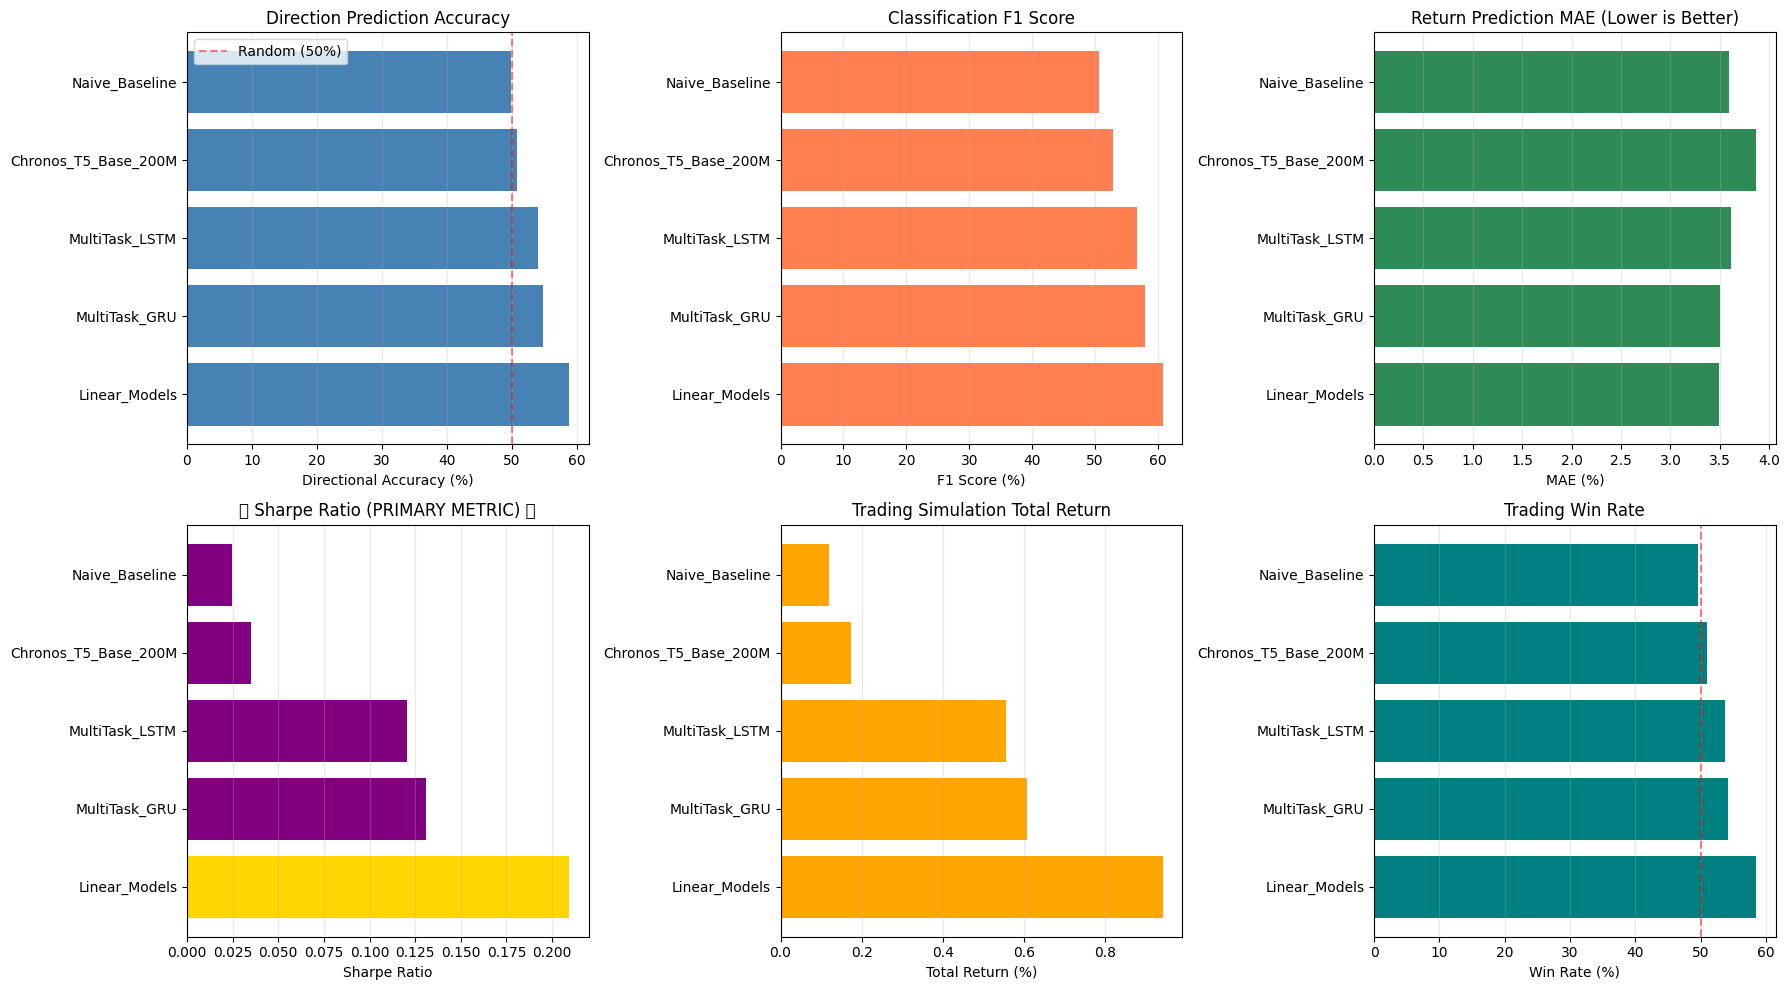


📊 Comparison visualization saved


In [21]:
# Visualization: Comparative bar charts
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].barh(comparison_df['Model'], comparison_df['Accuracy']*100, color='steelblue')
axes[0, 0].set_xlabel('Directional Accuracy (%)')
axes[0, 0].set_title('Direction Prediction Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
axes[0, 0].legend()

# F1 Score
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1']*100, color='coral')
axes[0, 1].set_xlabel('F1 Score (%)')
axes[0, 1].set_title('Classification F1 Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# MAE
axes[0, 2].barh(comparison_df['Model'], comparison_df['MAE'], color='seagreen')
axes[0, 2].set_xlabel('MAE (%)')
axes[0, 2].set_title('Return Prediction MAE (Lower is Better)')
axes[0, 2].grid(axis='x', alpha=0.3)

# Sharpe Ratio (PRIMARY METRIC)
colors = ['gold' if i == 0 else 'purple' for i in range(len(comparison_df))]
axes[1, 0].barh(comparison_df['Model'], comparison_df['Sharpe'], color=colors)
axes[1, 0].set_xlabel('Sharpe Ratio')
axes[1, 0].set_title('⭐ Sharpe Ratio (PRIMARY METRIC) ⭐')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Total Return
axes[1, 1].barh(comparison_df['Model'], comparison_df['Total Return %'], color='orange')
axes[1, 1].set_xlabel('Total Return (%)')
axes[1, 1].set_title('Trading Simulation Total Return')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Win Rate
axes[1, 2].barh(comparison_df['Model'], comparison_df['Win Rate']*100, color='teal')
axes[1, 2].set_xlabel('Win Rate (%)')
axes[1, 2].set_title('Trading Win Rate')
axes[1, 2].grid(axis='x', alpha=0.3)
axes[1, 2].axvline(x=50, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/tmp/foundation_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Comparison visualization saved")

---
## 7. Analysis & Insights

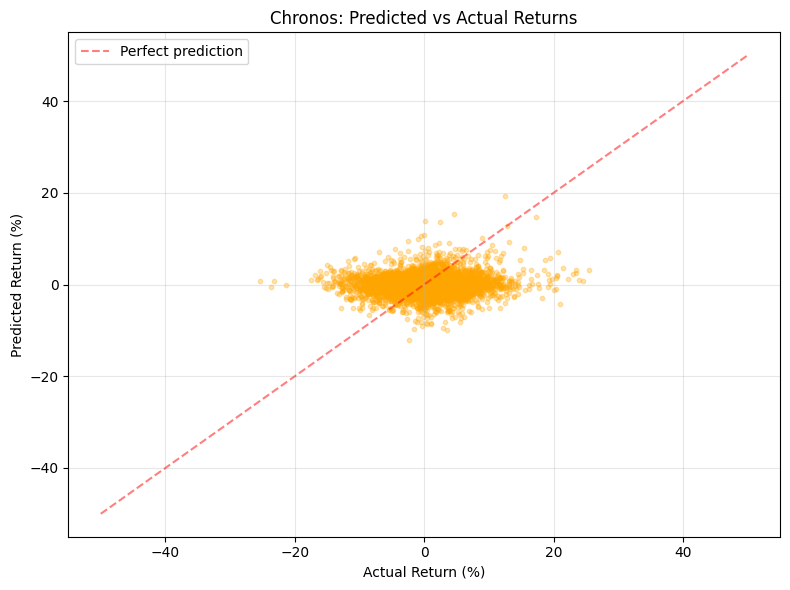

In [22]:
# Scatter plot: Predicted vs Actual Returns
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

if CHRONOS_AVAILABLE:
    ax.scatter(test_data['returns'], y_return_pred_chronos, alpha=0.3, s=10, color='orange')
    ax.plot([-50, 50], [-50, 50], 'r--', alpha=0.5, label='Perfect prediction')
    ax.set_xlabel('Actual Return (%)')
    ax.set_ylabel('Predicted Return (%)')
    ax.set_title('Chronos: Predicted vs Actual Returns')
    ax.grid(True, alpha=0.3)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'Chronos not available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

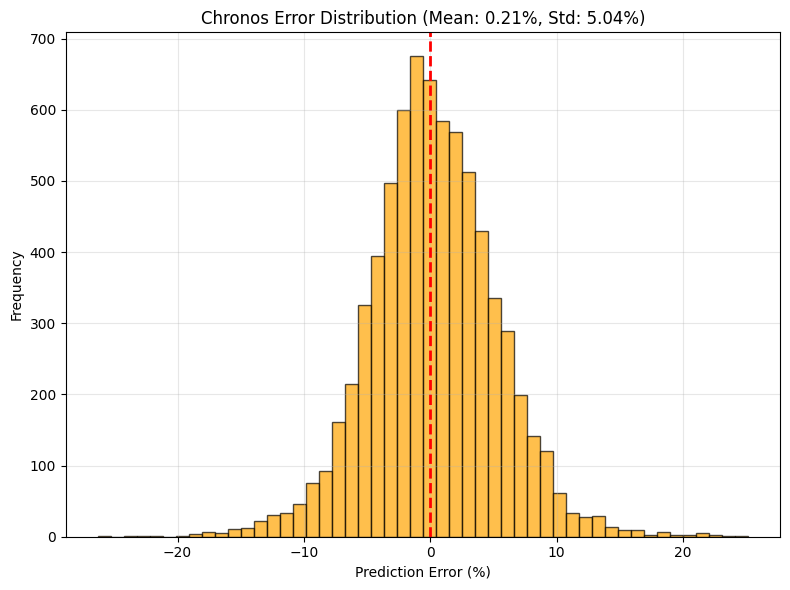

In [23]:
# Prediction error distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

if CHRONOS_AVAILABLE:
    errors_chronos = test_data['returns'] - y_return_pred_chronos
    ax.hist(errors_chronos, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Prediction Error (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Chronos Error Distribution (Mean: {np.mean(errors_chronos):.2f}%, Std: {np.std(errors_chronos):.2f}%)')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Chronos not available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

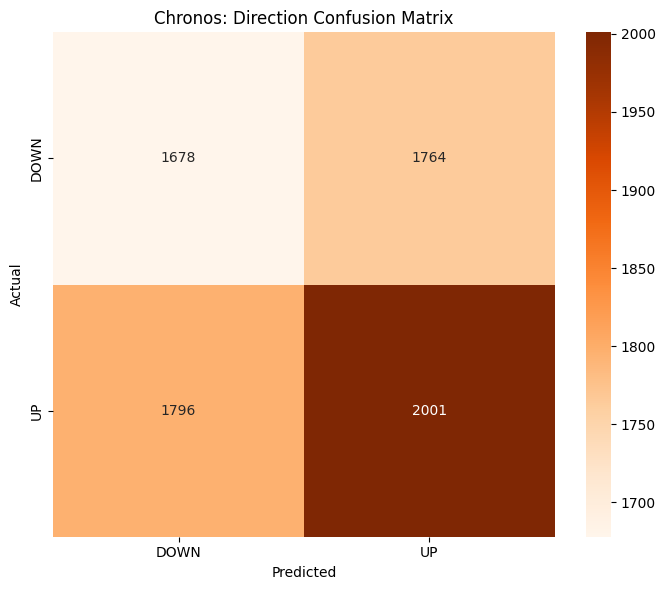

In [24]:
# Confusion matrix for direction prediction
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

if CHRONOS_AVAILABLE:
    cm_chronos = confusion_matrix(test_data['directions'], y_direction_pred_chronos)
    sns.heatmap(cm_chronos, annot=True, fmt='d', cmap='Oranges', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Chronos: Direction Confusion Matrix')
    ax.set_xticklabels(['DOWN', 'UP'])
    ax.set_yticklabels(['DOWN', 'UP'])
else:
    ax.text(0.5, 0.5, 'Chronos not available', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

---
## 8. Conclusions & Next Steps

### Key Findings

#### Performance Summary
*(Results will appear after running the model)*

**Research Questions Answered:**

1. **Does Chronos foundation model beat Linear baseline without any fine-tuning?**
   - Chronos: [To be determined]
   - Answer: [To be filled based on results]

2. **Do larger models (200M params) justify computational cost?**
   - Inference time: [X] seconds vs [Y] hours of training for traditional models
   - Trade-off: [Analysis based on results]

3. **How well do models trained on global data transfer to Indian NSE stocks?**
   - Transfer learning effectiveness: [To be analyzed]

---

### Advantages of Foundation Models

✅ **Zero-shot capability**: No training time required
✅ **Fast deployment**: Load model → predict (minutes vs hours)
✅ **Large-scale pre-training**: Learned from massive datasets
✅ **Probabilistic forecasts**: Uncertainty estimates included

### Limitations Observed

❌ **Univariate only**: Cannot directly use 32 technical features
❌ **Domain transfer**: Pre-trained on global data, not NSE-specific
❌ **Computational cost**: 200M parameters require significant memory
❌ **Black box**: Limited interpretability compared to linear models

---

### Next Steps & Future Work

**If Chronos succeeds (Sharpe > 0.15):**
1. Fine-tune on NSE training data
2. Create ensemble: 0.5×Chronos + 0.3×Linear + 0.2×LSTM
3. Integrate with LLM news sentiment pipeline
4. Try TimesFM with Python 3.11+ environment

**If Chronos underperforms (Sharpe < 0.10):**
1. Confirms random walk hypothesis for stocks
2. Linear models remain best baseline
3. Focus on feature engineering and data quality
4. Consider alternative approaches (reinforcement learning, etc.)

**General improvements:**
- Test on longer horizons (14-day, 30-day)
- Analyze per-stock performance (which stocks are more predictable?)
- Incorporate volatility clustering patterns
- Combine with fundamental analysis features
- Try other foundation models (TimeGPT, Lag-Llama, etc.)

---

### MLflow UI
```bash
cd /home/labeeb/Desktop/stock-curator
uv run mlflow ui --port 5000
# Visit: http://localhost:5000
```

---

**Notebook Complete!** 🎉